[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1vpA7J4p1legyAS0m5sqKeGQjSCGp_Nb4?usp=sharing)

Primitives generator for a robot with an [Ackermann Steering Geometry](https://github.com/robotics-laboratory/truck/blob/master/doc/svg/ackermann_vehicle.svg)

### Libraries
___

In [1]:
import math
import json
import types
import random
import requests
import numpy as np
import matplotlib.pyplot as plt

url = "https://raw.githubusercontent.com/jckantor/ND-Pyomo-Cookbook/main/python/helper.py"
helper = types.ModuleType("helper")
exec(requests.get(url).content, helper.__dict__)

helper.install_pyomo()
helper.install_ipopt()

from pyomo.environ import *
from pyomo.dae import *

pyomo was previously installed
ipopt was previously installed


In [2]:
class Pose:
  x: float              # 'x' coordinate of a primitve pose
  y: float              # 'y' coordinate of a primitve pose
  theta: float          # angle rad in interval [-pi; pi) of a primitve pose

  def __init__(self, x: float, y: float, theta: float):
    self.x = x
    self.y = y
    self.theta = theta

In [3]:
class Primitive:
  x_arr: list           # 'x' coordinates of all primitive poses
  y_arr: list           # 'y' coordinates of all primitive poses
  theta_arr: list       # 'theta' angles of all primitive poses
  len: float            # len of a primitive
  start_yaw_index: int  # yaw index of a first primitive pose
  end_yaw_index: int    # yaw index of an end primitive pose

  def __init__(self):
    self.x_arr = list()
    self.y_arr = list()
    self.theta_arr = list()
    self.len = float
    self.start_yaw_index = int
    self.end_yaw_index = int

In [4]:
class PrimitiveEncoder(json.JSONEncoder):
  def default(self, obj):
    if isinstance(obj, Primitive):
      return obj.__dict__
    return json.JSONEncoder.default(self, obj)

In [5]:
class Config:
  L: float              # car length
  an_max: float         # normal acceleration
  v_max: float          # fixed vehicle velocity m/s
  w_max: float          # max steering velocity rad/s for average servo
  phi_max: float        # max steering angle rad
  density: int          # primitive poses count

  def __init__(self, L: float, an_max: float, v_max: float, w_max: float, phi_max: float, density: int):
    self.L = L
    self.an_max = an_max
    self.v_max = v_max
    self.w_max = w_max
    self.phi_max = phi_max
    self.density = density

### Functions
___

In [7]:
def getYawIndexFromTheta(theta: float, yaw_step: float) -> int:
  '''
  Snapping a given angle rad to an index of a closest yaw angle rad

  Args:
      theta: angle rad in interval [-pi; pi)
      yaw_step: yaw angle rad step

  Return:
      index: index of a closest yaw angle rad
  '''

  index = round((theta + math.pi) / yaw_step)
  return index

In [8]:
def primitiveFromModel(m: ConcreteModel) -> Primitive:
  '''
  Generate primitive from a pyomo model

  Args:
      m: pyomo model

  Return:
      primitive
  '''

  primitive = Primitive()
  primitive.x_arr = [m.x[t]() for t in m.t]
  primitive.y_arr = [m.y[t]() for t in m.t]

  thetas = [m.theta[t]() for t in m.t]

  for theta in thetas:
    theta = math.remainder(theta, 2 * math.pi)
    if theta == math.pi: theta = -math.pi
    assert(theta >= -math.pi and theta < math.pi)
    primitive.theta_arr.append(theta)

  primitive.len = 0.0

  for i in range(1, len(primitive.x_arr)):
    primitive.len += \
      np.linalg.norm(
          np.array([primitive.x_arr[i], primitive.y_arr[i]]) - \
          np.array([primitive.x_arr[i - 1], primitive.y_arr[i - 1]])
      )

  # index of a closest yaw to a theta angle from a start pose
  primitive.start_yaw_index = getYawIndexFromTheta(primitive.theta_arr[0], yaw_step)
  primitive.end_yaw_index = getYawIndexFromTheta(primitive.theta_arr[-1], yaw_step)

  return primitive

In [9]:
def buildPrimitive(config: Config, start_pose: Pose, end_pose: Pose) -> Primitive:
  '''
  Solving an optimization problem using pyomo model
  for finding a kinematically executable primitive for a robot

  Args:
      config: optimization parameters
      start_pose: start primitive pose
      end_pose: end primitive pose

  Important:
      Changes in (x, y, theta) variables should be calculated relative
      to the middle of the robot's wheelbase (L/2) using these formulas:

        x_dot = v * cos(theta + beta)
        y_dot = v * sin(theta + beta)
        theta_dot = v / L * tan(phi) * cos(beta)

        where beta = atan(0.5 * tan(phi))

  Return:
      primitive
  '''

  # create a model object
  m = ConcreteModel()

  # define the independent variable
  m.tf = Var(domain=NonNegativeReals)
  m.t = ContinuousSet(bounds=(0, 1))

  # define control inputs
  m.w = Var(m.t)

  # define the dependent variables
  m.x = Var(m.t)
  m.y = Var(m.t)
  m.theta = Var(m.t)
  m.phi = Var(m.t, bounds=(-config.phi_max, +config.phi_max))

  # define derivatives
  m.x_dot = DerivativeVar(m.x)
  m.y_dot = DerivativeVar(m.y)
  m.theta_dot = DerivativeVar(m.theta)
  m.phi_dot = DerivativeVar(m.phi)

  # define the differential equation as constraints

  @m.Constraint(m.t)
  def ode_x(m, t):
      beta = atan(0.5 * tan(m.phi[t]))
      return m.x_dot[t] == (config.v_max * cos(m.theta[t] + beta)) * m.tf

  @m.Constraint(m.t)
  def ode_y(m, t):
      beta = atan(0.5 * tan(m.phi[t]))
      return m.y_dot[t] == (config.v_max * sin(m.theta[t] + beta)) * m.tf

  @m.Constraint(m.t)
  def ode_theta(m, t):
      beta = atan(0.5 * tan(m.phi[t]))
      return m.theta_dot[t] == (config.v_max / config.L * tan(m.phi[t]) * cos(beta)) * m.tf

  @m.Constraint(m.t)
  def ode_phi(m, t):
      return m.phi_dot[t] == m.tf * m.w[t]

  m.path_a1 = Constraint(m.t, rule=lambda m, t:  m.w[t] <= + m.tf * config.w_max)
  m.path_a2 = Constraint(m.t, rule=lambda m, t:  m.w[t] >= - m.tf * config.w_max)

  m.path_a3 = Constraint(m.t, rule=lambda m, t: config.v_max**2 * tan(m.phi[t]) <= +config.L * config.an_max)
  m.path_a4 = Constraint(m.t, rule=lambda m, t: config.v_max**2 * tan(m.phi[t]) >= -config.L * config.an_max)

  # initial conditions
  m.pc = ConstraintList()
  m.pc.add(m.x[0]==start_pose.x)
  m.pc.add(m.y[0]==start_pose.y)
  m.pc.add(m.theta[0]==start_pose.theta)

  # initial conditions on the control inputs
  m.pc.add(m.phi[0]==0)
  m.pc.add(m.w[0]==0)

  # final conditions
  m.pc.add(m.x[1.0]==end_pose.x)
  m.pc.add(m.y[1.0]==end_pose.y)
  m.pc.add(m.theta[1.0]==end_pose.theta)

  # final conditions on the control inputs
  m.pc.add(m.phi[1.0]==0)
  m.pc.add(m.w[1.0]==0)

  # define the optimization objective
  m.integral = Integral(m.t, wrt=m.t, rule=lambda m, t: (m.w[t]) ** 2)
  m.obj = Objective(expr=m.tf + m.integral)

  # transform and solve
  TransformationFactory('dae.finite_difference').apply_to(m, wrt=m.t, nfe=config.density)
  SolverFactory('ipopt').solve(m)

  primitive = primitiveFromModel(m)

  return primitive

In [10]:
def buildPrimitivesSet(config: Config, init_poses_arr: list) -> list:
  '''
  Build a set of primitives by a given config and a list of initial poses

  Args:
      config: optimization parameters
      init_poses_arr: list of start and end poses

  Return:
      primitives: set of primitives
  '''

  primitives = []
  for init_poses in init_poses_arr:
    start_pose = init_poses['start_pose']
    for end_pose in init_poses['end_poses']:
      primitive = buildPrimitive(config, start_pose, end_pose)
      primitives.append(primitive)

  return primitives

In [11]:
def drawPrimitivesSet(primitives: list, style:str = 'curves', scale:int = 5, s:int = 5, alpha:float = 1.0):
  '''
  Drawing of primitives set in different styles:
    style = 'curves', 'points' or 'points_with_thetas'
  '''

  plt.figure(figsize=(scale, scale))

  for primitive in primitives:
    if style == 'curves':
      plt.plot(
        primitive.x_arr,
        primitive.y_arr,
        alpha=alpha
      )
    elif style == 'points':
      plt.scatter(
        primitive.x_arr,
        primitive.y_arr,
        s=s,
        alpha=alpha
      )
    elif style == 'points_with_thetas':
      plt.quiver(
        primitive.x_arr,
        primitive.y_arr,
        np.cos(primitive.theta_arr),
        np.sin(primitive.theta_arr),
        color='black',
        scale=25,
        width=0.003,
        alpha=alpha
      )

      plt.scatter(
        primitive.x_arr,
        primitive.y_arr,
        s=s,
        alpha=alpha
      )
    else:
      assert False, 'Not valid value of \'style\' arg'

  plt.axis('equal')
  plt.grid(True)

### Config
___

Values in `config` are based on [model.yaml](https://github.com/robotics-laboratory/truck/blob/master/packages/model/config/model.yaml) file

In [12]:
config = Config(
    L = 0.505,
    an_max = 2.0,
    v_max = 0.5,
    w_max = 3.14,
    phi_max = 0.7,
    density = 15,
)

In [13]:
yaw_step = math.radians(360 / 12)
yaws = np.array([-math.pi + (yaw_step * i) for i in range(12)])

assert(all(yaws >= -math.pi) and all(yaws < math.pi))

print('Yaws angles rad:\n')

for yaw in yaws:
  print(yaw)

Yaws angles rad:

-3.141592653589793
-2.6179938779914944
-2.0943951023931957
-1.5707963267948966
-1.0471975511965979
-0.5235987755982991
0.0
0.5235987755982987
1.0471975511965974
1.5707963267948966
2.094395102393195
2.617993877991494


### Generate Primitives Set
___

#### **Set 1**

In [14]:
init_poses_arr = [
  {
    'start_pose': Pose(0, 0, math.radians(90)),

    'end_poses': [
      Pose(0.0, 0.6, math.radians(90)),
      Pose(-0.4, 0.6, math.radians(90+30)),
      Pose(0.4, 0.6, math.radians(90-30)),
    ]
  },

  {
    'start_pose': Pose(0, 0, math.radians(-90)),

    'end_poses': [
      Pose(0.0, -0.6, math.radians(-90)),
      Pose(0.4, -0.6, math.radians(-90+30)),
      Pose(-0.4, -0.6, math.radians(-90-30)),
    ]
  },

  {
    'start_pose': Pose(0, 0, math.radians(0)),

    'end_poses': [
      Pose(0.6, 0.0, math.radians(0)),
      Pose(0.6, 0.4, math.radians(0+30)),
      Pose(0.6, -0.4, math.radians(0-30)),
    ]
  },

  {
    'start_pose': Pose(0, 0, math.radians(-180)),

    'end_poses': [
      Pose(-0.6, 0.0, math.radians(-180)),
      Pose(-0.6, -0.4, math.radians(-180+30)),
      Pose(-0.6, 0.4, math.radians(-180-30)),
    ]
  },
]

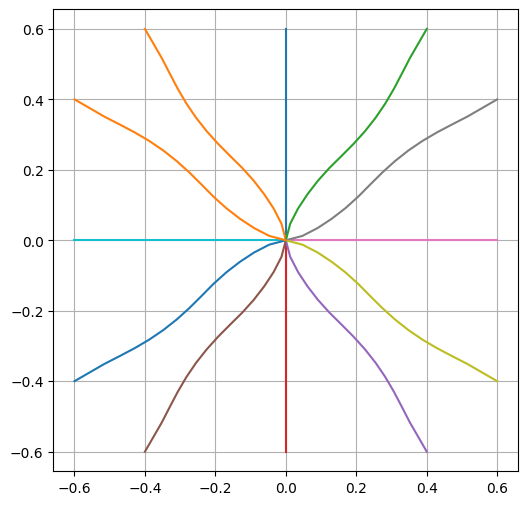

In [15]:
primitives_set_1 = buildPrimitivesSet(config, init_poses_arr)

drawPrimitivesSet(primitives_set_1, style='curves', scale=6, s=5, alpha=1.0)

#### **Set 2**

In [16]:
init_poses_arr = [
  {
    'start_pose': Pose(0, 0, math.radians(60)),

    'end_poses': [
      Pose(0.4, 0.6, math.radians(60)),
      Pose(0.0, 0.8, math.radians(60+30)),
      Pose(0.6, 0.4, math.radians(60-30)),
    ]
  },

  {
    'start_pose': Pose(0, 0, math.radians(-60)),

    'end_poses': [
      Pose(0.4, -0.6, math.radians(-60)),
      Pose(0.6, -0.4, math.radians(-60+30)),
      Pose(0.0, -0.8, math.radians(-60-30)),
    ]
  },

  {
    'start_pose': Pose(0, 0, math.radians(120)),

    'end_poses': [
      Pose(-0.4, 0.6, math.radians(120)),
      Pose(-0.6, 0.4, math.radians(120+30)),
      Pose(0.0, 0.8, math.radians(120-30)),
    ]
  },

  {
    'start_pose': Pose(0, 0, math.radians(-120)),

    'end_poses': [
      Pose(-0.4, -0.6, math.radians(-120)),
      Pose(0.0, -0.8, math.radians(-120+30)),
      Pose(-0.6, -0.4, math.radians(-120-30)),
    ]
  },
]

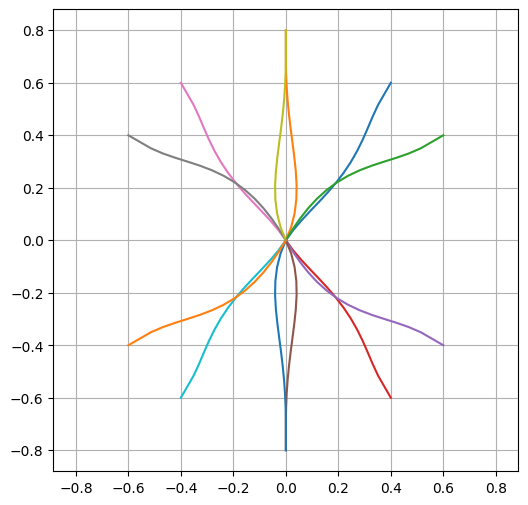

In [17]:
primitives_set_2 = buildPrimitivesSet(config, init_poses_arr)

drawPrimitivesSet(primitives_set_2, style='curves', scale=6, s=5, alpha=1.0)

#### **Set 3**

In [18]:
init_poses_arr = [
  {
    'start_pose': Pose(0, 0, math.radians(30)),

    'end_poses': {
      Pose(0.6, 0.4, math.radians(30)),
      Pose(0.4, 0.6, math.radians(30+30)),
      Pose(0.8, 0.0, math.radians(30-30)),
    }
  },

  {
    'start_pose': Pose(0, 0, math.radians(-30)),

    'end_poses': [
      Pose(0.6, -0.4, math.radians(-30)),
      Pose(0.8, 0.0, math.radians(-30+30)),
      Pose(0.4, -0.6, math.radians(-30-30)),
    ]
  },

  {
    'start_pose': Pose(0, 0, math.radians(-150)),

    'end_poses': [
      Pose(-0.6, -0.4, math.radians(-150)),
      Pose(-0.4, -0.6, math.radians(-150+30)),
      Pose(-0.8, 0.0, math.radians(-150-30)),
    ]
  },

  {
    'start_pose': Pose(0, 0, math.radians(150)),

    'end_poses': [
      Pose(-0.6, 0.4, math.radians(150)),
      Pose(-0.8, 0.0, math.radians(150+30)),
      Pose(-0.4, 0.6, math.radians(150-30)),
    ]
  },
]

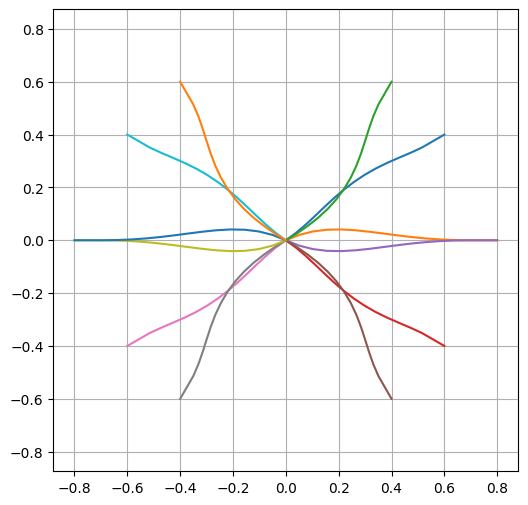

In [19]:
primitives_set_3 = buildPrimitivesSet(config, init_poses_arr)

drawPrimitivesSet(primitives_set_3, style='curves', scale=6, s=5, alpha=1.0)

#### **Set 4**

In [20]:
init_poses_arr = [
  {
    'start_pose': Pose(0, 0, math.radians(90)),

    'end_poses': {
      Pose(0.8, 0.8, math.radians(90-60)),
      Pose(-0.8, 0.8, math.radians(90+60)),

      Pose(1.2, 0.6, math.radians(90-90)),
      Pose(-1.2, 0.6, math.radians(90+90)),
    }
  },

  {
    'start_pose': Pose(0, 0, math.radians(-90)),

    'end_poses': {
      Pose(0.8, -0.8, math.radians(-90+60)),
      Pose(-0.8, -0.8, math.radians(-90-60)),

      Pose(1.2, -0.6, math.radians(-90+90)),
      Pose(-1.2, -0.6, math.radians(-90-90)),
    }
  },

  {
    'start_pose': Pose(0, 0, math.radians(0)),

    'end_poses': {
      Pose(0.8, 0.8, math.radians(0+60)),
      Pose(0.8, -0.8, math.radians(0-60)),

      Pose(0.6, 1.2, math.radians(0+90)),
      Pose(0.6, -1.2, math.radians(0-90)),
    }
  },

  {
    'start_pose': Pose(0, 0, math.radians(-180)),

    'end_poses': {
      Pose(-0.8, 0.8, math.radians(-180-60)),
      Pose(-0.8, -0.8, math.radians(-180+60)),

      Pose(-0.6, 1.2, math.radians(-180-90)),
      Pose(-0.6, -1.2, math.radians(-180+90)),
    }
  },
]

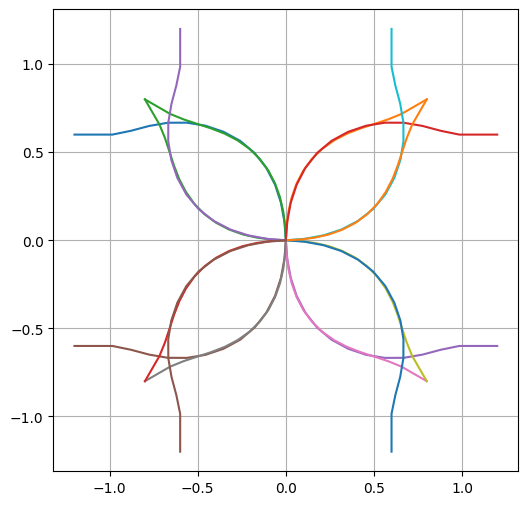

In [21]:
primitives_set_4 = buildPrimitivesSet(config, init_poses_arr)

drawPrimitivesSet(primitives_set_4, style='curves', scale=6, s=5, alpha=1.0)

#### **Set 5**

In [22]:
init_poses_arr = [
  {
    'start_pose': Pose(0, 0, math.radians(30)),

    'end_poses': {
      Pose(-0.2, 1.2, math.radians(30+90)),
      Pose(0.2, 1.0, math.radians(30+60)),

      Pose(1.0, -0.8, math.radians(30-90)),
      Pose(1.0, -0.4, math.radians(30-60)),
    }
  },

  {
    'start_pose': Pose(0, 0, math.radians(-30)),

    'end_poses': {
      Pose(-0.2, -1.2, math.radians(-30-90)),
      Pose(0.2, -1.0, math.radians(-30-60)),

      Pose(1.0, 0.8, math.radians(-30+90)),
      Pose(1.0, 0.4, math.radians(-30+60)),
    }
  },

  {
    'start_pose': Pose(0, 0, math.radians(150)),

    'end_poses': {
      Pose(-0.2, 1.0, math.radians(150-60)),
      Pose(0.2, 1.2, math.radians(150-90)),

      Pose(-1.0, -0.4, math.radians(150+60)),
      Pose(-1.0, -0.8, math.radians(150+90)),
    }
  },

  {
    'start_pose': Pose(0, 0, math.radians(-150)),

    'end_poses': {
      Pose(-0.2, -1.0, math.radians(-150+60)),
      Pose(0.2, -1.2, math.radians(-150+90)),

      Pose(-1.0, 0.4, math.radians(-150-60)),
      Pose(-1.0, 0.8, math.radians(-150-90)),
    }
  }
]

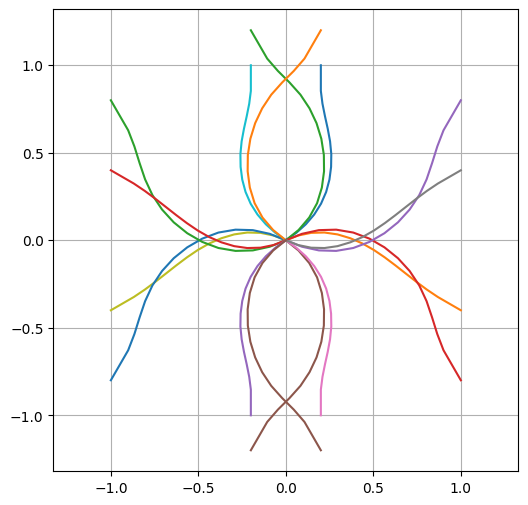

In [23]:
primitives_set_5 = buildPrimitivesSet(config, init_poses_arr)

drawPrimitivesSet(primitives_set_5, style='curves', scale=6, s=5, alpha=1.0)

#### **Set 6**

In [24]:
init_poses_arr = [
  {
    'start_pose': Pose(0, 0, math.radians(60)),

    'end_poses': {
      Pose(-0.4, 1.0, math.radians(60+60)),
      Pose(-0.8, 1.0, math.radians(60+90)),

      Pose(1.0, 0.2, math.radians(60-60)),
      Pose(1.2, -0.2, math.radians(60-90)),
    }
  },

  {
    'start_pose': Pose(0, 0, math.radians(-60)),

    'end_poses': {
      Pose(1.0, -0.2, math.radians(-60+60)),
      Pose(1.2, 0.2, math.radians(-60+90)),

      Pose(-0.4, -1.0, math.radians(-60-60)),
      Pose(-0.8, -1.0, math.radians(-60-90)),
    }
  },

  {
    'start_pose': Pose(0, 0, math.radians(120)),

    'end_poses': {
      Pose(0.4, 1.0, math.radians(120-60)),
      Pose(0.8, 1.0, math.radians(120-90)),

      Pose(-1.0, 0.2, math.radians(120+60)),
      Pose(-1.2, -0.2, math.radians(120+90)),
    }
  },

  {
    'start_pose': Pose(0, 0, math.radians(-120)),

    'end_poses': {
      Pose(-1.0, -0.2, math.radians(-120-60)),
      Pose(-1.2, 0.2, math.radians(-120-90)),

      Pose(0.4, -1.0, math.radians(-120+60)),
      Pose(0.8, -1.0, math.radians(-120+90)),
    }
  },
]

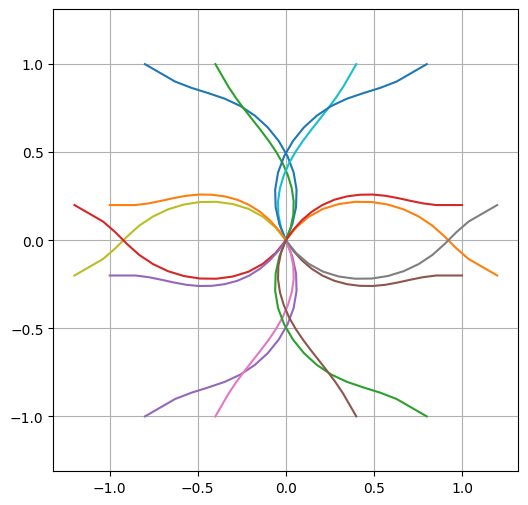

In [25]:
primitives_set_6 = buildPrimitivesSet(config, init_poses_arr)

drawPrimitivesSet(primitives_set_6, style='curves', scale=6, s=5, alpha=1.0)

#### **Set 7**

In [26]:
init_poses_arr = [
  {
    'start_pose': Pose(0, 0, math.radians(0)),

    'end_poses': {
      Pose(0.2, 0.0, math.radians(0)),
    }
  },

  {
    'start_pose': Pose(0, 0, math.radians(-180)),

    'end_poses': {
      Pose(-0.2, 0.0, math.radians(-180)),
    }
  },

  {
    'start_pose': Pose(0, 0, math.radians(90)),

    'end_poses': {
      Pose(0.0, 0.2, math.radians(90)),
    }
  },

  {
    'start_pose': Pose(0, 0, math.radians(-90)),

    'end_poses': {
      Pose(0.0, -0.2, math.radians(-90)),
    }
  },


  {
    'start_pose': Pose(0, 0, math.radians(30)),

    'end_poses': {
      Pose(0.4, 0.2, math.radians(30)),
    }
  },

  {
    'start_pose': Pose(0, 0, math.radians(-30)),

    'end_poses': {
      Pose(0.4, -0.2, math.radians(-30)),
    }
  },

  {
    'start_pose': Pose(0, 0, math.radians(150)),

    'end_poses': {
      Pose(-0.4, 0.2, math.radians(150)),
    }
  },

  {
    'start_pose': Pose(0, 0, math.radians(-150)),

    'end_poses': {
      Pose(-0.4, -0.2, math.radians(-150)),
    }
  },


  {
    'start_pose': Pose(0, 0, math.radians(60)),

    'end_poses': {
      Pose(0.2, 0.4, math.radians(60)),
    }
  },

  {
    'start_pose': Pose(0, 0, math.radians(-60)),

    'end_poses': {
      Pose(0.2, -0.4, math.radians(-60)),
    }
  },

  {
    'start_pose': Pose(0, 0, math.radians(120)),

    'end_poses': {
      Pose(-0.2, 0.4, math.radians(120)),
    }
  },

  {
    'start_pose': Pose(0, 0, math.radians(-120)),

    'end_poses': {
      Pose(-0.2, -0.4, math.radians(-120)),
    }
  },
]

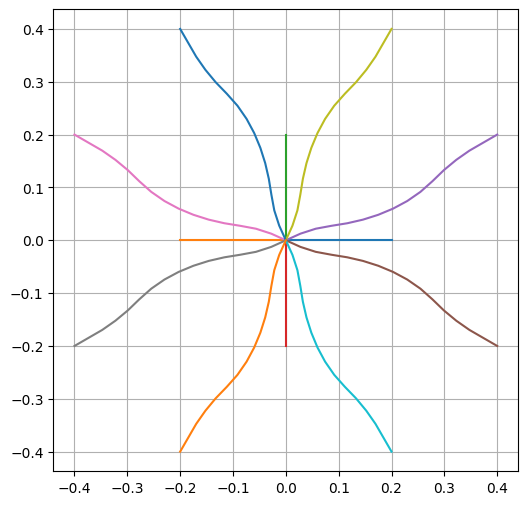

In [27]:
primitives_set_7 = buildPrimitivesSet(config, init_poses_arr)

drawPrimitivesSet(primitives_set_7, style='curves', scale=6, s=5, alpha=1.0)

#### Join Sets

Final primitives set is a union of earlier defined sets

In [28]:
primitives_simple = \
  primitives_set_1 + \
  primitives_set_2 + \
  primitives_set_3

primitives_advanced = \
  primitives_set_1 + \
  primitives_set_2 + \
  primitives_set_3 + \
  primitives_set_4 + \
  primitives_set_5 + \
  primitives_set_6 + \
  primitives_set_7

In [29]:
len(primitives_simple), len(primitives_advanced)

(36, 96)

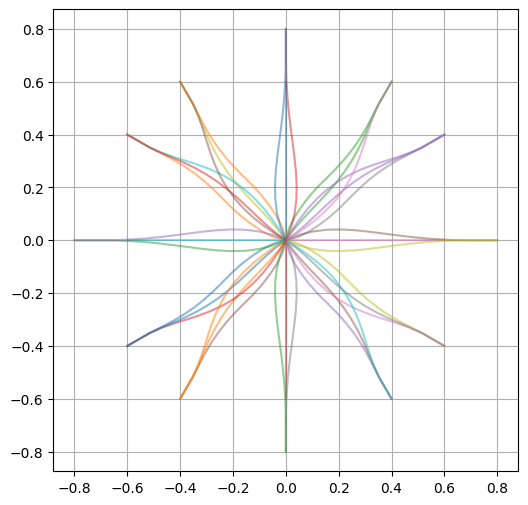

In [30]:
drawPrimitivesSet(primitives_simple, style='curves', scale=6, s=5, alpha=0.5)

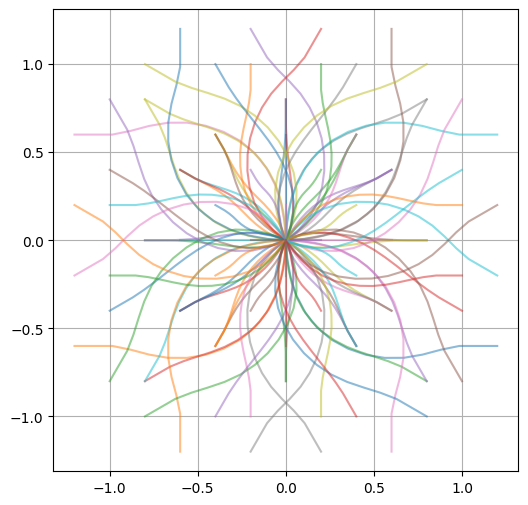

In [31]:
drawPrimitivesSet(primitives_advanced, style='curves', scale=6, s=5, alpha=0.5)

### Prepare JSON
___

#### Primitives Indexing

* in every primitive we know `start_yaw_index` - index which corresponds to the yaw angle closest to the theta angle from a start pose

* primitives are grouped based on their `start_yaw_index` values in `yaw_to_primitives_indexing` array

* this index relation of the corresponding yaws and primitives are stored in `.json` file

In [33]:
yaw_to_primitives_indexing = [[] for _ in range(12)]

for i in range(len(primitives_advanced)):
  yaw_to_primitives_indexing[primitives_advanced[i].start_yaw_index].append(i)

print(yaw_to_primitives_indexing)

[[9, 10, 11, 48, 49, 50, 51, 85], [30, 31, 32, 64, 65, 66, 67, 91], [21, 22, 23, 80, 81, 82, 83, 95], [3, 4, 5, 40, 41, 42, 43, 87], [15, 16, 17, 72, 73, 74, 75, 93], [27, 28, 29, 56, 57, 58, 59, 89], [6, 7, 8, 44, 45, 46, 47, 84], [24, 25, 26, 52, 53, 54, 55, 88], [12, 13, 14, 68, 69, 70, 71, 92], [0, 1, 2, 36, 37, 38, 39, 86], [18, 19, 20, 76, 77, 78, 79, 94], [33, 34, 35, 60, 61, 62, 63, 90]]


#### Build JSON

In [34]:
json_data = dict()
json_data['yaw_to_primitives_indexing'] = yaw_to_primitives_indexing
json_data['primitives'] = primitives_advanced

file_name = 'primitives'

with open('{0}.json'.format(file_name), 'w') as f:
    json.dump(json_data, f, cls=PrimitiveEncoder)

JSON Structure:

```json
{
  "yaw_to_primitives_indexing": {
    [],
    [],
    ...
  },

  "primitives": [
    {
      "x_arr": [],
      "y_arr": [],
      "theta_arr": [],
      "len": 0.6,
      "start_yaw_index": 0,
      "end_yaw_index": 11
    },
    {
      ...
    },
    ...
  ]
}
```

___
___